In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


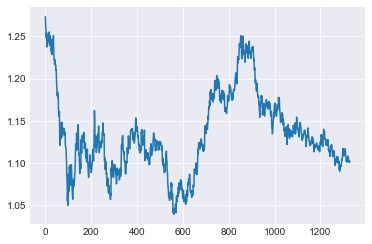

In [2]:
eur_usd = pd.read_csv("./my_EUR_USD_Hdata.csv")
# print(data)
data=eur_usd.as_matrix(columns=['Price'])
price=np.reshape(data,1329)
plt.plot(price)


# Applying Augmented Dickey fuller test to EUR_USD data

In [3]:
from statsmodels.tsa.stattools import adfuller
X = eur_usd['Price'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.193092
p-value: 0.020388
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


results show that we can reject null hypothesis and claim the series is stationary 

# Plotting Auto correlation fuction of the time series

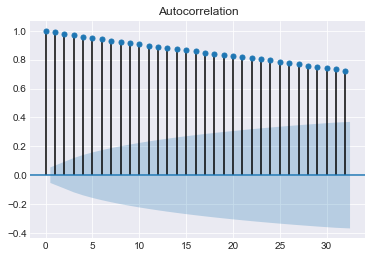

In [4]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(eur_usd['Price'])
pyplot.show()

# Plotting partial auto correlation fuction of the time series

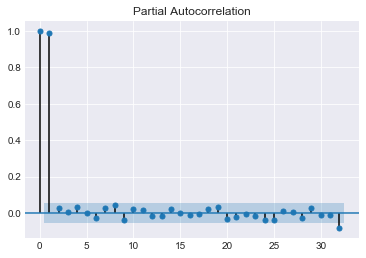

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(eur_usd['Price'])
pyplot.show()

### These plots show that an AR(2) model (auto regressive model with 2 lags) is appropriate for this series but just to experiment we will try ar(1),ar(2),ar(3) and ar(4)

# Building AR(1) model 

In [6]:
with pm.Model() as arprice:
#choosing normal distribution with mean 0 and variance 1 as a prior because beta can only be between -1 and +1 
#else the time series isn't stationary 
    beta = pm.Normal('beta',  mu=0, sigma=1.0)
    likelhood = pm.AR('price', beta, sigma=1.0, observed=X)

In [7]:
with arprice:
    trace = pm.sample(2000, tune=4000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:23<00:00, 1011.87draws/s]


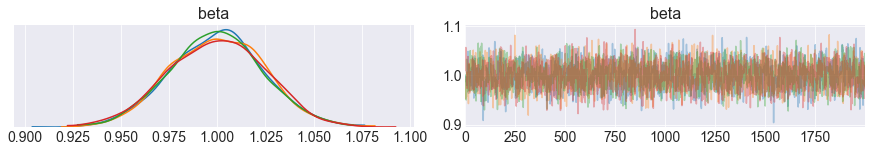

In [8]:
az.plot_trace(trace);

# Testing AR(1) accuracy

In [9]:
eur_usdt = pd.read_csv("./my_EUR_USD_Tdata.csv")
eur_usdt.head()

,Date,Price,Open,High,Low,Change %,days
0,2-Dec-19,1.1079,1.1014,1.1091,1.1003,0.56%,1
1,3-Dec-19,1.1083,1.1079,1.1095,1.1066,0.04%,2
2,4-Dec-19,1.1078,1.1082,1.1117,1.1067,-0.05%,3
3,5-Dec-19,1.1104,1.1079,1.1110,1.1078,0.23%,4
4,6-Dec-19,1.1059,1.1106,1.1111,1.1040,-0.41%,5


In [10]:

eur_usdt['predicted_price_ar1']= ""

eur_usdt['predicted_price_ar1'].iloc[0]= trace['beta'].mean()*eur_usd.iloc[-1]['Price']
for i in  range(1,36):
    eur_usdt['predicted_price_ar1'].iloc[i]= trace['beta'].mean()*eur_usdt.iloc[i-1]['Price']
    
eur_usdt.head()

C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Price,Open,High,Low,Change %,days,predicted_price_ar1
0,2-Dec-19,1.1079,1.1014,1.1091,1.1003,0.56%,1,1.10115
1,3-Dec-19,1.1083,1.1079,1.1095,1.1066,0.04%,2,1.10735
2,4-Dec-19,1.1078,1.1082,1.1117,1.1067,-0.05%,3,1.10775
3,5-Dec-19,1.1104,1.1079,1.1110,1.1078,0.23%,4,1.10725
4,6-Dec-19,1.1059,1.1106,1.1111,1.1040,-0.41%,5,1.10985


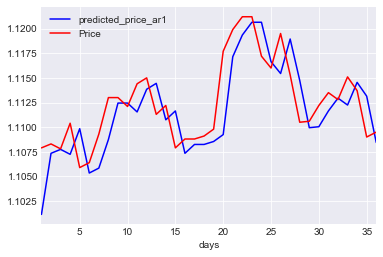

In [11]:
ax = plt.gca()

eur_usdt.plot(kind='line',y='predicted_price_ar1',x='days',color='blue',ax=ax)
eur_usdt.plot(kind='line',y='Price',x='days', color='red', ax=ax)

plt.show()


# building AR(2) model

In [12]:
with pm.Model() as arprice:
    beta0 = pm.Normal('beta0', mu=0, sigma=1.0)
    beta1 = pm.Normal('beta1',  mu=0, sigma=1.0)
    likelhood = pm.AR('price', [beta0, beta1], sigma=1.0, observed=X)

In [13]:
with arprice:
    trace = pm.sample(2000, tune=4000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [01:30<00:00, 265.20draws/s]
The number of effective samples is smaller than 25% for some parameters.


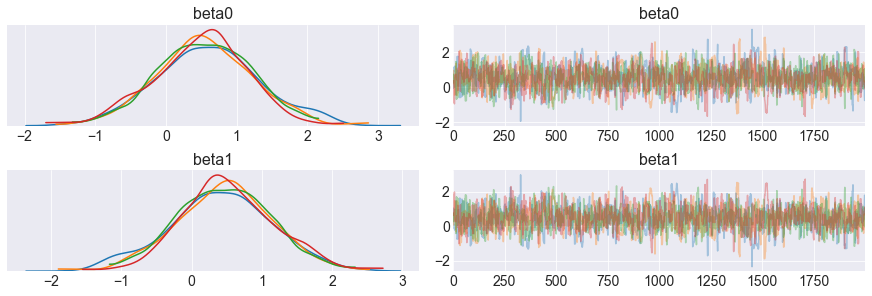

In [14]:
az.plot_trace(trace);

# Testing AR(2) accuracy

In [15]:
eur_usdt['predicted_price_ar2']= ""
eur_usdt['predicted_price_ar2'].iloc[0]= trace['beta0'].mean()*eur_usd.iloc[-1]['Price']+trace['beta1'].mean()*eur_usd.iloc[-2]['Price']

eur_usdt['predicted_price_ar2'].iloc[1]= trace['beta0'].mean()*eur_usdt.iloc[0]['Price']+trace['beta1'].mean()*eur_usd.iloc[-2]['Price']

for i in  range(2,36):
    eur_usdt['predicted_price_ar2'].iloc[i]= trace['beta0'].mean()*eur_usdt.iloc[i-1]['Price']+trace['beta1'].mean()*eur_usdt.iloc[i-2]['Price']
    
eur_usdt.head()

C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Price,Open,High,Low,Change %,days,predicted_price_ar1,predicted_price_ar2
0,2-Dec-19,1.1079,1.1014,1.1091,1.1003,0.56%,1,1.10115,1.10021
1,3-Dec-19,1.1083,1.1079,1.1095,1.1066,0.04%,2,1.10735,1.10354
2,4-Dec-19,1.1078,1.1082,1.1117,1.1067,-0.05%,3,1.10775,1.10712
3,5-Dec-19,1.1104,1.1079,1.1110,1.1078,0.23%,4,1.10725,1.10704
4,6-Dec-19,1.1059,1.1106,1.1111,1.1040,-0.41%,5,1.10985,1.10821


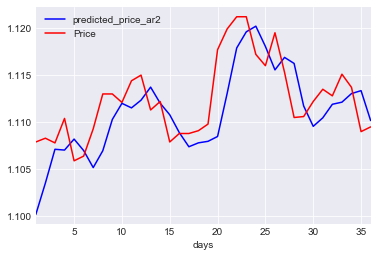

In [16]:
ax = plt.gca()

eur_usdt.plot(kind='line',y='predicted_price_ar2',x='days',color='blue',ax=ax)
eur_usdt.plot(kind='line',y='Price',x='days', color='red', ax=ax)

plt.show()


# building AR(3) model

In [17]:
with pm.Model() as arprice:
    beta0 = pm.Normal('beta0', mu=0, sigma=1.0)
    beta1 = pm.Normal('beta1',  mu=0, sigma=1.0)
    beta2 = pm.Normal('beta2',  mu=0, sigma=1.0)
    likelhood = pm.AR('price', [beta0, beta1,beta2], sigma=1.0, observed=X)

In [18]:
with arprice:
    trace = pm.sample(2000, tune=4000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [04:02<00:00, 99.16draws/s] 


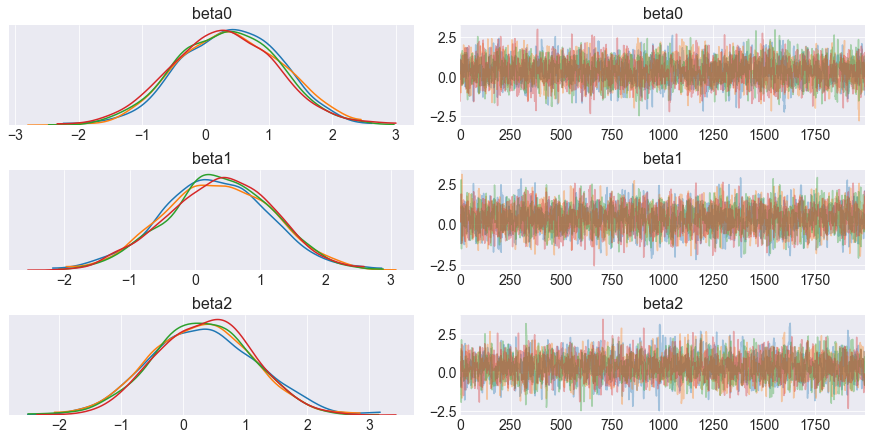

In [19]:
az.plot_trace(trace);

# Testing AR(3) accuracy

In [20]:
eur_usdt['predicted_price_ar3']= ""
eur_usdt['predicted_price_ar3'].iloc[0]= trace['beta0'].mean()*eur_usd.iloc[-1]['Price']+trace['beta1'].mean()*eur_usd.iloc[-2]['Price']+trace['beta2'].mean()*eur_usd.iloc[-3]['Price']

eur_usdt['predicted_price_ar3'].iloc[1]= trace['beta0'].mean()*eur_usdt.iloc[0]['Price']+trace['beta1'].mean()*eur_usd.iloc[-1]['Price']+trace['beta2'].mean()*eur_usd.iloc[-2]['Price']

eur_usdt['predicted_price_ar3'].iloc[2]= trace['beta0'].mean()*eur_usdt.iloc[1]['Price']+trace['beta1'].mean()*eur_usdt.iloc[0]['Price']+trace['beta2'].mean()*eur_usd.iloc[-1]['Price']

for i in  range(3,36):
    eur_usdt['predicted_price_ar3'].iloc[i]= trace['beta0'].mean()*eur_usdt.iloc[i-1]['Price']+trace['beta1'].mean()*eur_usdt.iloc[i-2]['Price']+trace['beta2'].mean()*eur_usdt.iloc[i-3]['Price']
    
eur_usdt.head()

C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Price,Open,High,Low,Change %,days,predicted_price_ar1,predicted_price_ar2,predicted_price_ar3
0,2-Dec-19,1.1079,1.1014,1.1091,1.1003,0.56%,1,1.10115,1.10021,1.1002
1,3-Dec-19,1.1083,1.1079,1.1095,1.1066,0.04%,2,1.10735,1.10354,1.10274
2,4-Dec-19,1.1078,1.1082,1.1117,1.1067,-0.05%,3,1.10775,1.10712,1.10537
3,5-Dec-19,1.1104,1.1079,1.1110,1.1078,0.23%,4,1.10725,1.10704,1.10726
4,6-Dec-19,1.1059,1.1106,1.1111,1.1040,-0.41%,5,1.10985,1.10821,1.1081


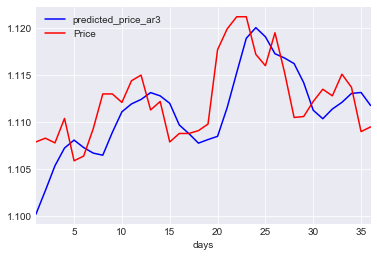

In [21]:
ax = plt.gca()

eur_usdt.plot(kind='line',y='predicted_price_ar3',x='days',color='blue',ax=ax)
eur_usdt.plot(kind='line',y='Price',x='days', color='red', ax=ax)

plt.show()


# Building AR(4) model

In [22]:
with pm.Model() as arprice:
    beta0 = pm.Normal('beta0', mu=0, sigma=1.0)
    beta1 = pm.Normal('beta1',  mu=0, sigma=1.0)
    beta2 = pm.Normal('beta2',  mu=0, sigma=1.0)
    beta3 = pm.Normal('beta3',  mu=0, sigma=1.0)
    likelhood = pm.AR('price', [beta0, beta1, beta2, beta3], sigma=1.0, observed=X)

In [23]:
with arprice:
    trace = pm.sample(2000, tune=4000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [06:17<00:00, 63.57draws/s]


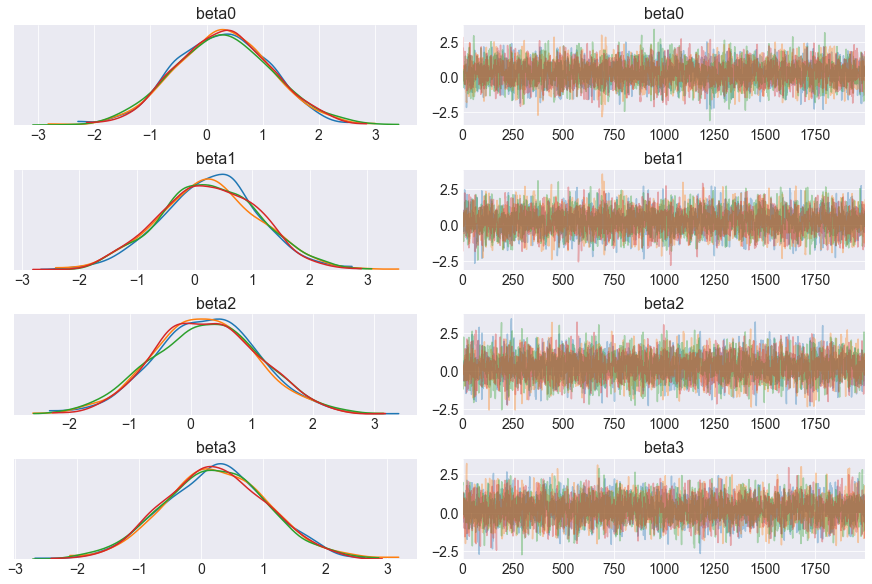

In [24]:
az.plot_trace(trace);

# Testing AR(4) accuracy

In [25]:
eur_usdt['predicted_price_ar4']= ""
eur_usdt['predicted_price_ar4'].iloc[0]= trace['beta0'].mean()*eur_usd.iloc[-1]['Price']+trace['beta1'].mean()*eur_usd.iloc[-2]['Price']+trace['beta2'].mean()*eur_usd.iloc[-3]['Price']+trace['beta3'].mean()*eur_usd.iloc[-4]['Price']

eur_usdt['predicted_price_ar4'].iloc[1]= trace['beta0'].mean()*eur_usdt.iloc[0]['Price']+trace['beta1'].mean()*eur_usd.iloc[-1]['Price']+trace['beta0'].mean()*eur_usd.iloc[-2]['Price']+trace['beta1'].mean()*eur_usd.iloc[-3]['Price']

eur_usdt['predicted_price_ar4'].iloc[2]= trace['beta0'].mean()*eur_usdt.iloc[1]['Price']+trace['beta1'].mean()*eur_usdt.iloc[0]['Price']+trace['beta0'].mean()*eur_usd.iloc[-1]['Price']+trace['beta1'].mean()*eur_usd.iloc[-2]['Price']

eur_usdt['predicted_price_ar4'].iloc[3]= trace['beta0'].mean()*eur_usdt.iloc[2]['Price']+trace['beta1'].mean()*eur_usdt.iloc[1]['Price']+trace['beta0'].mean()*eur_usdt.iloc[0]['Price']+trace['beta1'].mean()*eur_usd.iloc[-1]['Price']

for i in  range(4,36):
    eur_usdt['predicted_price_ar4'].iloc[i]= trace['beta0'].mean()*eur_usdt.iloc[i-1]['Price']+trace['beta1'].mean()*eur_usdt.iloc[i-2]['Price']+trace['beta2'].mean()*eur_usdt.iloc[i-3]['Price']+trace['beta3'].mean()*eur_usdt.iloc[i-4]['Price']

    
eur_usdt.head()

C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Price,Open,High,Low,Change %,days,predicted_price_ar1,predicted_price_ar2,predicted_price_ar3,predicted_price_ar4
0,2-Dec-19,1.1079,1.1014,1.1091,1.1003,0.56%,1,1.10115,1.10021,1.1002,1.10075
1,3-Dec-19,1.1083,1.1079,1.1095,1.1066,0.04%,2,1.10735,1.10354,1.10274,1.16385
2,4-Dec-19,1.1078,1.1082,1.1117,1.1067,-0.05%,3,1.10775,1.10712,1.10537,1.16583
3,5-Dec-19,1.1104,1.1079,1.1110,1.1078,0.23%,4,1.10725,1.10704,1.10726,1.1678
4,6-Dec-19,1.1059,1.1106,1.1111,1.1040,-0.41%,5,1.10985,1.10821,1.1081,1.10822


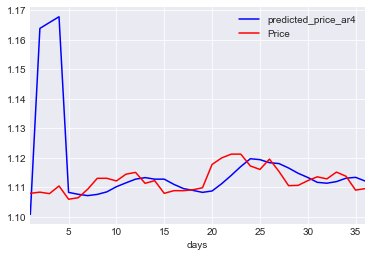

In [26]:
ax = plt.gca()

eur_usdt.plot(kind='line',y='predicted_price_ar4',x='days',color='blue',ax=ax)
eur_usdt.plot(kind='line',y='Price',x='days', color='red', ax=ax)

plt.show()


To conclude, experiments ar2,ar3 and ar4 curve keeps getting increasingly smooth and give sufficient results whereas ar1 just returns the previous lag values.